## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [44]:
# If you didn't download it yet, please get the relevant file now!
# !wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [6]:
# 1
import numpy as np 
import pandas as pd
# prima di tutto mi si chiede di creare un dataframe con N righe dove N può essere un numero a caso scelto tra 10^3 e il massimo numero di righe in data_000637.txt
# !curl -O https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
filename = "data_000637.txt"
with open(filename,"r") as filehandle :
    dataframe = pd.read_csv(filehandle)
#display(dataframe) # la prima colonna in assoluto costituisce gli indici delle altre 
maxnumrow = dataframe.shape[0] # sempre tramite il metodo shape come negli array numpy  
# N = np.random.randint(10**3,maxnumrow) se volessi fare ogni esecuzione un dataframe diverso
N = 539063
# con questo posso selezionare le prime N righe del dataframe 
dataframe = dataframe.iloc[:N, :]
display(dataframe)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
539058,1,0,58,3869205625,1552,6
539059,1,1,16,3869205625,1564,12
539060,1,0,139,3869205625,1565,0
539061,1,0,62,3869205625,1556,3


In [7]:
# 2
bx = dataframe.loc[:, 'BX_COUNTER']
bxinorbit = max(bx)
print(bxinorbit) # essendo molti i campioni trovo come massimo numero di bx prima che il count venga resettato e quindi venga aggiunta un'unità di orbit il valore stampato. Il massimo in questo caso tiene in conto il fatto che bx altro non è che come la lancetta dei minuti dell'orologio, appena giunge ad un valore (il massimo) scocca il minuto e bx riparte da zero a contare. E' come avere delle condizioni a contorno periodiche del numero massimo di "ticchettii" che bx può compiere 

3563


In [8]:
# 3-4
# Per capire quanto è durata la misura posso calcolare la differenza tra il minimo numero di orbit contate e il massimo numero. Vista la consequenzialità delle misure basta considerare il primo e l'ultimo orbit 
#timebx = 25
#timelastedorbits = dataframe.loc[len(dataframe)-1, 'ORBIT_CNT'] - dataframe.loc[0, 'ORBIT_CNT']
# abbiamo detto che un orbit sono circa 3563 bx e un bx sono 25ns dunque in secondi il tempo impiegato è uguale a timelastedorbits*bxinorbit*timebx
#timelasted = timelastedorbits*bxinorbit*timebx
#print("Time lasted in nanoseconds is: ", timelasted)

In [9]:
# 3-4
# per ciascuna riga devo calcolare il tempo corrispondente a quella misura pari a: 25/30*tdc + 25*bx + 3563*25*orbit. Posso allora creare una colonna castata a np.array con una lista scritta tramite list comprehension in cui itero sugli indici del dataframe. Il tempo che è durata la misura sarà l'ultimo elemento della lista che sto costruendo 
dataframe['timelasted'] = np.array([25/30*dataframe.loc[index, 'TDC_MEAS'] + 25*dataframe.loc[index, 'BX_COUNTER'] + 3563*25*dataframe.loc[index, 'ORBIT_CNT'] for index in dataframe.index])
# il tempo impiegato dalla misura è pari alla differenza tra l'ultimo elemento della nuova colonna meno il primo 
print("time lasted in nanoseconds is: ", dataframe.loc[len(dataframe)-1, 'timelasted'] - dataframe.loc[0,'timelasted'])

time lasted in nanoseconds is:  486150832.5


In [10]:
# 5 
# Mi si chiede di rimpiazzare i valori della colonna HEAD randomicamente con 0 oppure 1
dataframe['HEAD'] = np.array([np.random.randint(0,2) for i in range(len(dataframe))])
dataframe.head() # per mostrare le prime cinque righe del dataframe

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timelasted
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14


In [11]:
# 6 
dataframe1 = dataframe[dataframe['HEAD'] == 1]
dataframe1.head() # si vede che in questo modo ho selezionato soltanto le righe con HEAD uguale a uno tramite una maschera logica

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timelasted
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14


Text(0.5, 0, 'Time')

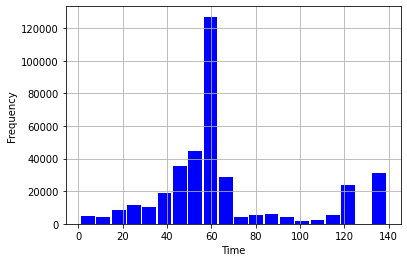

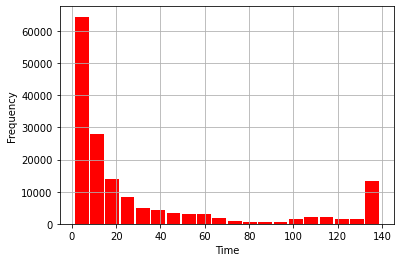

In [13]:
# 7 MALE INTERPRETATO 
# Ora devo rappresentare il numero di conteggi (colonna TDC_CHANNEL) in funzione del tempo (che qua posso considerare banalmente come l'indice) per i due FPGAs corrispondenti a FPGA = 0 e FPGA = 1
from matplotlib import pyplot as plt
%matplotlib inline
# seleziono le colonne in questione tramite una mask 
fpga0 = dataframe[dataframe['FPGA'] == 0].loc[:, 'TDC_CHANNEL'] 
fpga1 = dataframe[dataframe['FPGA'] == 1].loc[:, 'TDC_CHANNEL']
# seleziono due series contenente una colonna di indici e un'altra i counts che vogliamo rappresentare in un istogramma. Le due series contengono ciascuna due colonne del dataframe
plt.figure(1)
fpga0.plot.hist(grid=True, bins=20, rwidth=0.9, color='blue')
plt.xlabel('Time')
plt.figure(2)
fpga1.plot.hist(grid=True, bins=20, rwidth=0.9, color='red')
plt.xlabel('Time')

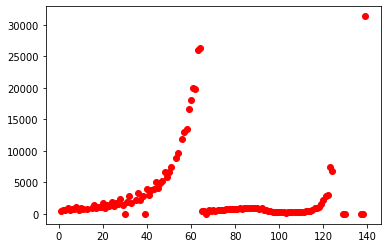

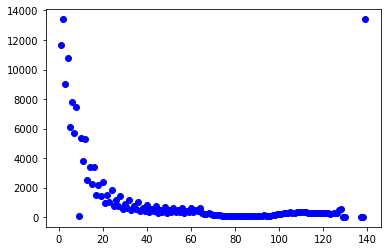

In [14]:
# 7 
# Considero i due dataframe aventi rispettivamente FPGA = 0 e FPGA = 1. Per ciascuno dei due, conto il numero di volte che un certo tdc channel compare. A questo punto posso rappresentare i conteggi per ciascun canale
fpga0 = dataframe[dataframe['FPGA'] == 0]
plt.figure(1)
plt.scatter((fpga0['TDC_CHANNEL'].value_counts().index), (fpga0['TDC_CHANNEL'].value_counts().values), color = 'red')
fpga1 = dataframe[dataframe['FPGA'] == 1]
plt.figure(2)
plt.scatter((fpga1['TDC_CHANNEL'].value_counts().index), (fpga1['TDC_CHANNEL'].value_counts().values), color = 'blue')
# dalle due series conto quante volte compaiono i valori all'interno della colonna TDC_CHANNEL e rappresento i conteggi del sensore al variare del canale di misurazione


In [96]:
# 8
# Devo trovare tramite groupby quei tdc_channels con più conteggi nel dataframe iniziale 
a = dataframe.groupby('TDC_CHANNEL').count() # non avendo selezionato le colonne del dataframe in cui restringerci la funzione count viene applicata a tutte le colonne, e poichè abbiamo raggruppato in tdc channel vengono contati quante volte compaiono i singoli canali restuendo tante righe quanti sono i canali diversi tra loro 
# .groups è un attribute di un dataframe e .count è un attribute a sua volta del dataframe ma non dell'oggetto che esce fuori da .groups (che è una sorta di dizionario)
display(a)
a.sort_values(by = 'TDC_CHANNEL', ascending = False) 
# Pongo su "False" l'ordine crescente. 
# Stampo un dataframe dove troviamo tutti i canali in ordine di conteggi dal maggiore al minore, con tutte le colonne per il motivo detto prima.

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timelasted
TDC_CHANNEL,,,,,,
1,12170,12170,12170,12170,12170,12170
2,14034,14034,14034,14034,14034,14034
3,9675,9675,9675,9675,9675,9675
4,11729,11729,11729,11729,11729,11729
5,6689,6689,6689,6689,6689,6689
...,...,...,...,...,...,...
129,13,13,13,13,13,13
130,26,26,26,26,26,26
137,21,21,21,21,21,21


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timelasted
TDC_CHANNEL,,,,,,
139,44784,44784,44784,44784,44784,44784
138,22,22,22,22,22,22
137,21,21,21,21,21,21
130,26,26,26,26,26,26
129,13,13,13,13,13,13
...,...,...,...,...,...,...
5,6689,6689,6689,6689,6689,6689
4,11729,11729,11729,11729,11729,11729
3,9675,9675,9675,9675,9675,9675


In [135]:
# 9
# mi si chiede di contare gli orbits che compaiono una sola volta con il vincolo che siano associati ad almeno una misura nel canale TDC = 139 
# display(dataframe)
display(dataframe)
orbitgroup = dataframe[['TDC_CHANNEL', 'ORBIT_CNT']].groupby('TDC_CHANNEL')
# Innanzitutto restringo il dataaframe alle colonne contenenti le features che mi interessano ovvero il canale della misura e il tempo impiegato dalla misura stessa. 
#orbitgroup.get_group(139)
#orbitgroup.count()
canale = orbitgroup.get_group(139) # adesso devo applicare una funzione all'ultima colonna che è quella di trovare gli elementi unici diversi tra loro
serie = canale['ORBIT_CNT'] 
# così facendo passo dal dataframe alla serie
serie.unique() 

#for orbit, group in orbitgroup :
    #print(orbit) # sono le varie classi che abbiamo raggruppato 
    #print(group) # stampiamo l'intero gruppo per ciascuna classe cioè per ciascun orbit diverso 
# per visualizzare i vari gruppi ottenuti utilizzerei la proprietà di un datafram di iterare al suo interno 

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timelasted
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
...,...,...,...,...,...,...,...
539058,1,0,58,3869205625,1552,6,3.446495e+14
539059,0,1,16,3869205625,1564,12,3.446495e+14
539060,1,0,139,3869205625,1565,0,3.446495e+14
539061,1,0,62,3869205625,1556,3,3.446495e+14


array([3869200167, 3869200168, 3869200169, ..., 3869205623, 3869205624,
       3869205625], dtype=int64)